# Jake's Data Challenge 2 Solution

The set up is that there is an A/B price test and the customer wants to know:
1) whether the company should seel at the higher or lower price
2) Could the test have run for a shorter time and, if so, for how many days?
3) What actionable insights in the customer base are there that could increase sales?

In [157]:
%matplotlib inline

import pandas as pd
from IPython.display import HTML, display
import scipy.stats as st
import math
import seaborn as sns
# The data lives in 2 .csv files, so let's load those.
# results = pd.read_csv('test_results.csv')
# users = pd.read_csv('user_table.csv')

In [2]:
results.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [3]:
users.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


## A first look at the data.
There are a few things I want to look at before anything.
First, I want to know whether the company has tracked users.  The question is whether I could tell if a user looks, leaves, and then comes back and buys.
Second, I want to know whether there are some visitor categories that never result in a purchase under any conditions before I start looking at the individual price points.  My suspision is that mobile might device visitors could be such a category, as well as any potential out of US visitors. I'm just going to assume that 

In [4]:
# are the user_id's unique?
if len(results['user_id'])==len(set(results['user_id'])): print 'User IDs are not tracked'

User IDs are not tracked


In [24]:
# Well, if the users are not being tracked, let's make sure that some user properties don't preclude a sale
# merge the tables:
results = results.join(users.set_index('user_id'), on='user_id')
results.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [138]:
# Let's print the list of unique categories that could be problematic: country, device
print results['device'].unique()
print results['country'].unique()
print results['source'].unique()

['mobile' 'web']
['USA' nan]
['ads_facebook' 'seo-google' 'ads-bing' 'direct_traffic' 'ads-google'
 'seo_facebook' 'friend_referral' 'ads_other' 'ads-yahoo' 'seo-yahoo'
 'seo-bing' 'seo-other']


In [39]:
# What is going on with that?
print 'Entries in the results table:', results.shape[0]
print 'Entries in the users table:', users.shape[0]
print 'Difference:', results.loc[results['country'] != 'USA'].shape[0]

Entries in the results table: 316800
Entries in the users table: 275616
Difference: 41184


Interesting.  There are 41184 entries that do not have a geolocation associated with them.  I wonder if there are any sales in that set.  If it does have a geolocation, then it's in the USA.
Let's build a table for my potential problem classes and just the total number of sales in each.

In [42]:
# results['converted'].loc[(results['country'] != 'USA') & (results['device'] == 'mobile')].sum()
table2 = [["", "USA","No Location", "Total"],
          ["mobile",results['converted'].loc[(results['device'] == 'mobile') & (results['country'] == 'USA')].sum(),
               results['converted'].loc[(results['device'] == 'mobile') & (results['country'] != 'USA')].sum(),
               results['converted'].loc[(results['device'] == 'mobile')].sum()],
          ["web",results['converted'].loc[(results['device'] == 'web') & (results['country'] == 'USA')].sum(),
               results['converted'].loc[(results['device'] == 'web') & (results['country'] != 'USA')].sum(),
               results['converted'].loc[(results['device'] == 'web')].sum()],
        ["Total", results['converted'].loc[(results['country'] == 'USA')].sum(),
               results['converted'].loc[(results['country'] != 'USA')].sum(), results['converted'].sum()]]

display(HTML(
    '<table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in table2)
        )
 ))

,USA,No Location,Total
mobile,2990,470,3460
web,2029,319,2348
Total,5019,789,5808


I now believe that there are no categories of user behavior that should be disregarded based on potential behavior-purchase incompatibility.

To address the first question of whether the test worked.  Let me do some quick math to determine what the change in conversion rate would need to be for the company to increase revenue with the higher price:
The break even point is:
current_rate*delta_rate*new_price = current_rate*old_price

delta_rate = old_price/new_price = 0.66 or 66%

Anything less than a 66% drop in conversion rate, and the company would increase revenue with the higher price.

The first question is whether the test is even sufficiently powered to see this.  I think a one sided hypothesis test is appropriate.
I assume the conversion rate over the old price condition during the test is the historic conversion rate.

In [53]:
#  conversion rate:
p1 = float(results['converted'].loc[results['test'] == 0].sum())/(results['user_id'].loc[results['test'] == 0].count())
print 'Current conversion rate: ', p1

4035
202727
Current conversion rate:  0.0199036142201


In [54]:
# determine the conversion rate we wish to know if the new price affect is less than
p2 = p1*39/59
print 'Conversion rate plus maximum change: ', p2

Conversion rate plus maximum change:  0.0131566263489


In [91]:
# For now I assume the 1/3 to 2/3 test to control split numbers are correct
# The minimum number of samples we'd need to be able to see this effect at alpha = 0.05 and beta = 0.2 is:

def minSamples(p1,p2,power, alpha):
    Z_b = st.norm.ppf(power)
    Z_a = st.norm.ppf(1-alpha)
    n_test = (2*p1*(1-p1)+p2*(1-p2))*((Z_b+Z_a)/(p1-p2))**2
    return n_test

# The minimum number of samples we'd need to be able to see this effect at standard A/B test criteria :
# alpha = 0.05 and power = 80% is:

n_std = minSamples(p1,p2,.8,.05)
print 'Number of required samples in the test bucket under standard test success criteria (5% false positive, 80% power):'
print int(math.ceil(n_std))

Number of required samples in the test bucket under standard test success criteria (5% false positive, 80% power):
7063


In [95]:
# Now, how many do we have in the test bucket?
print 'Number of samples in the test bucket:', results['user_id'].loc[results['test'] == 1].count()

Number of samples in the test bucket: 114073


# Power analysis
The test has ample sample size to see the effect at the level where revenue would decrease overall under the new price. In fact, the test has ample power to see an effect of that size with extremly stringent conditions for false positive chance and power.

In [94]:
n_test = minSamples(p1,p2,.99,.001)
print 'Number of required samples in the test bucket under very stringent conditions'
print '(0.1% false positive, 99% power):', int(math.ceil(n_test))

n_test = minSamples(p1,p2,.999,.0001)
print 'Number of required samples in the test bucket under extremely stringent conditions'
print '(0.01% false positive, 99.9% power):', int(math.ceil(n_test))


Number of required samples in the test bucket under very stringent conditions
(0.1% false positive, 99% power): 33514
Number of required samples in the test bucket under extremely stringent conditions
(0.01% false positive, 99.9% power): 52963


In [73]:
# What is the actual conversion rate was under the test:
ptest = float(results['converted'].loc[results['test'] == 1].sum())/(results['user_id'].loc[results['test'] == 1].count())
print 'Test conversion rate: ', ptest

# And also the Z-score and then the confidence limit:
def zScore(p1,p2,n1,n2):
    z_score = abs(p1-p2)/(((p1*(1-p1))/n1)+((p2*(1-p2))/n2))**0.5
    return z_score

def confidence(z):
    conf_limit = st.norm.cdf(z)
    return conf_limit

print 'Z score:',zScore(p1,ptest,results['user_id'].loc[results['test'] == 0].count(),
                        results['user_id'].loc[results['test'] == 1].count())

print 'Z score:',zScore(p2,ptest,results['user_id'].loc[results['test'] == 0].count(),
                        results['user_id'].loc[results['test'] == 1].count())

Test conversion rate:  0.0155426788109
Z score: 9.08607899769
Z score: 5.35983573048


# Test Result
With Z-scores substantially larger than the predetermined one-sided threshold for a 0.1% chance of false positive (Z-score > 3.1), we can conclude that the conversion rate from the test is indeed lower the current conversion rate, as well as larger than the calculate rate at which revenue would decrease under the new price.

Before I turn my attention to a power analysis to answer the question of whether the test could have been run for less time, let me see whether the conversion rate had any noticable differences depending on where the traffic came from.

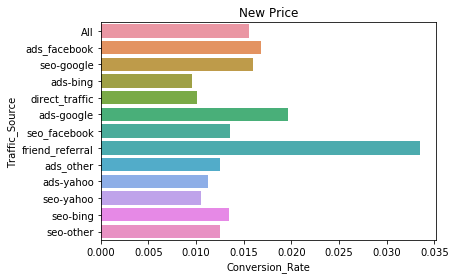

In [179]:
p_overall = float(results['converted'].loc[results['test'] == 0].sum())/(results['user_id'].loc[results['test'] == 0].
                                                                        count())

s = ['All']
rate = [p_overall]

for i in results['source'].unique():
#     print (results['converted'].loc[(results['test'] == 0) & (results['source']==i)].sum())
#     print (results['user_id'].loc[(results['test'] == 0) & (results['source']==i)].count())

    temp = float((results['converted'].loc[(results['test'] == 0) & (results['source']==i)].sum()))/(results['user_id'].loc[(results['test'] == 0) & (results['source']==i)].count())
    s.append(i)
    rate.append(temp)

Sources = pd.DataFrame()
Sources['Traffic_Source']=s
Sources['Conversion_Rate']=rate

# ax = sns.barplot(x="Conversion_Rate", y="Traffic_Source", data=Sources)
# ax.set_title('Current Price')

p_overall2 = float(results['converted'].loc[results['test'] == 1].sum())/(results['user_id'].loc[results['test'] == 1].
                                                                        count())

s = ['All']
rate = [p_overall2]

for i in results['source'].unique():
#     print (results['converted'].loc[(results['test'] == 0) & (results['source']==i)].sum())
#     print (results['user_id'].loc[(results['test'] == 0) & (results['source']==i)].count())

    temp = float((results['converted'].loc[(results['test'] == 1) & (results['source']==i)].sum()))/(results['user_id'].loc[(results['test'] == 1) & (results['source']==i)].count())
    s.append(i)
    rate.append(temp)

Sources2 = pd.DataFrame()
Sources2['Traffic_Source']=s
Sources2['Conversion_Rate']=rate

ax1 = sns.barplot(x="Conversion_Rate", y="Traffic_Source", data=Sources2)
ax1.set_title('New Price')

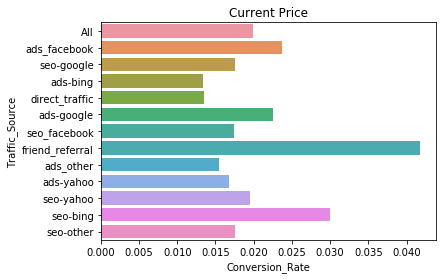

In [178]:
ax = sns.barplot(x="Conversion_Rate", y="Traffic_Source", data=Sources)
ax.set_title('Current Price')

# Results
The test worked and the new price increases revenue.

Looking at the breakdown of conversion rate by where the traffic comes from, it is certainly clear that referrals result in the highest conversion rate, both for the new price and the old price.  Ads placed on bing and yahoo seem to be less effective and represent a potential avenue to target to increase revenue.